## CS8982 Solar PV Detection Project - Final Deep Learning Model Presentation

This notebook is a clean version of the notebook that was used to test a variety of different deep learning frameworks for the binary image classification problem of detecting solar panels from high resolution orthoimagery (HRO). The HRO images were obtained from the USGS Earth Explorer sampled from various places in the San Francisco Bay area with Contra Costa county. Each scene from the USGS is 1ft (or .3m) resolution per pixel, and standard 5,000x5,000 pixel space. Each of these scenes were split into 2500 tiles of 100x100 pixels space in order to be annotated with binary labels, either having a solar panel present or not. A total of ~27,000 images were randomly sampled and annotated, creating 688 positive labels, and over 26,000 negative labels.

Three trial runs were performed with different splits between negative and positive labels:

1) 10:1

2) 100:3 (original rate of positive label discovery)

3) 1:1

Various deep learning models were trained as seen below using a basic Sequential model, as well as popular frameworks that are very deep, e.g. 20 to over 100 hidden layers.

#### Import required libraries

In [2]:
import os
import numpy as np
import pandas as pd
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras import backend as K
from tensorflow.python.client import device_lib
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import kerastuner as kt
from kerastuner.tuners import RandomSearch

### Observe Tensorflow version and GPU is visible

These two cells just validate the Tensorflow version installed, and that Tensorflow can see the CPU and GPU devices

In [2]:
tf.__version__

'2.3.1'

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5642190034637556104
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16565787184366753094
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4951408640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1103030964701983909
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16350516486517801030
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Configure image data generators and flow directories

As mentioned above, three different splits between train and validation sets were experimented with. In the end, an equal 1:1 split between train and validation appeared to yield the best results. Below the flow from directory methods were pulled from the balanced dataset folders.

In [4]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    zca_whitening=True,
#     zca_epsilon=0.1, # default 0.000001
#     featurewise_std_normalization=True,
#     rotation_range=90,
#     fill_mode="nearest",
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
#     validation_split=0.2
)
valid_gen = ImageDataGenerator(rescale=1./255)

c:\users\kenns\miniconda3\envs\gpu_env\lib\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [5]:
train_generator = train_gen.flow_from_directory(
#     'images/original_set/train',
    'images/balanced_set/train',
    color_mode="rgb",
    target_size=(100,100),
    batch_size=100,
    class_mode='binary',
    classes=['none','solar'],
    shuffle=True)
validation_generator = valid_gen.flow_from_directory(
#     'images/original_set/valid',
    'images/balanced_set/valid',
    color_mode="rgb",
    target_size=(100,100),
    batch_size=100,
    class_mode='binary',
    classes=['none','solar'])

Found 1100 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


### Load ResNet101, VGG16 and Inception models from Keras applications API

Here, we import just a few of the popular deep learning frameworks for image classification proplems. The performance from these can are considered a benchmark for many new algorithms being developed in the literature.

In [6]:
resnet101_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights='imagenet', # None or other weights
    input_tensor=None,
    input_shape=(100, 100, 3),
    pooling='max' # max or avg
)

In [7]:
# make it so the base layer weights from transfer learning are not trainable
resnet101_model.trainable = False

In [8]:
vgg16_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet', # None or other weights
    input_tensor=None,
    input_shape=(100, 100, 3),
    pooling='max' # max or avg
)

In [9]:
# make it so the base layer weights from transfer learning are not trainable
vgg16_model.trainable = False 

In [10]:
incV3_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet', # None or other weights
    input_tensor=None,
    input_shape=(100, 100, 3),
    pooling='max' # max or avg
)

In [11]:
# make it so the base layer weights from transfer learning are not trainable
incV3_model.trainable = False

In [12]:
models = [(resnet101_model, 'resnet'), (vgg16_model, 'vgg'), (incV3_model, 'inception')]

### Fit and evaluate each model with the balanced image dataset

The training history for each of the three deep learning frameworks will be fit on the balanced dataset, and saved to a dictionary so that they can be evaluated in a side by side comparison after.

In [13]:
def build_model(core):
    output_layer = layers.Dense(1, activation='sigmoid')
    concat_model = tf.keras.Sequential([core, output_layer])
    concat_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    print(concat_model.summary())
    return concat_model

In [14]:
model_history = {}

In [70]:
for model in models:
    print(f'Training and evaluating {model[1]} model')
    
    # grab a model from the model hashmap
    this_model = build_model(model[0])
    
    # fit the model using the train and validation image data generators
    history = this_model.fit(
        train_generator, 
        epochs=30,
        validation_data=validation_generator,
        batch_size=550, 
        verbose=1)
    
    # store the current model history in hashmap for plotting accuracy and loss
    model_history[model[1]] = history
    
    # predict the probability distribution of the data
#     predictions=this_model.predict_generator(validation_generator, steps=28, verbose=1)

    # get the class with highest probability for each sample
#     y_pred = np.argmax(predictions, axis=-1)

    # get the classification report
#     print(classification_report(test_labels, y_pred))
    
    print('-'*100)
    
# code to fetch the predictions using the image data generator obtained from
# https://stackoverflow.com/questions/59909304/classification-report-using-prediction-generator-method

Training and evaluating resnet model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 42,660,225
Trainable params: 2,049
Non-trainable params: 42,658,176
_________________________________________________________________
None
Epoch 1/30
11/11 [==============================] - 4s 376ms/step - loss: 1.2088 - accuracy: 0.5027 - val_loss: 0.6950 - val_accuracy: 0.4855
Epoch 2/30
11/11 [==============================] - 2s 168ms/step - loss: 0.7768 - accuracy: 0.4945 - val_loss: 0.7716 - val_accuracy: 0.5000
Epoch 3/30
11/11 [==============================] - 2s 203ms/step - loss: 0.6810 - accuracy: 0.5436 - val_loss: 0.6224 - val_accuracy: 0.7246
Epoch 4/30
11/11 [==============

### Evaluate model performance

From the charts below, we can see that the VGG16 and InceptionV3 models are performing 5% better than the ResNet101 model on average once the first two models converge around epoch 7 or 10. After that they hardly diverge. All of the models performance tends to saturate around that same point in the training process. The InceptionV3 validation results are  lower than its training results and stay that way after epoch 2, so perhaps some signs of overfitting. Looking at Loss results for binary crossentropy, we see a slightly different story. Again ResNet101 performs slightly worse with a gap in .1-.2 loss, while VGG16 and InceptionV3 form a tight convergence after the second epoch. However, observing their validation sets, the gap in loss for InceptionV3 between training and validation sets is much wider, again reinforcing the idea that the model is overfitting around epoch 2.  Therefore, VGG16 appears to be the most performant model on this dataset without any further tuning of hyperparameters, as it's training and validation loss stay divergent througha ll epochs.

In [22]:
def plot_model_accuracy(model_history):
    legend_list = []
    fig = plt.figure(figsize=(10,8))
    for key, history in model_history.items():
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'], ':')
        train_label = key + '_train'
        legend_list.append(train_label)
        test_label = key + '_valid'
        legend_list.append(test_label)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(legend_list, loc='lower right')
    plt.ylim(.4, 1)
    plt.show()

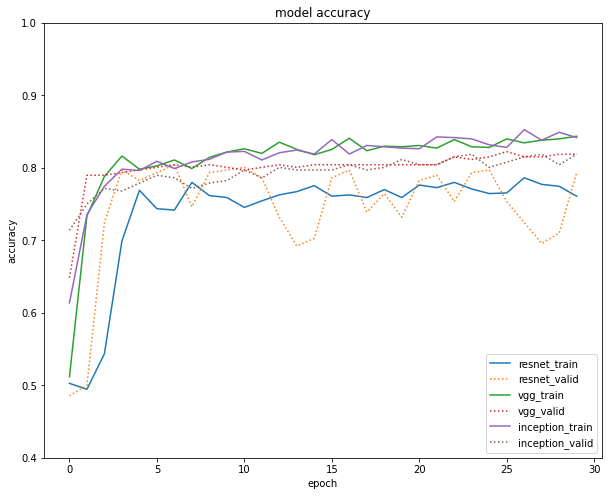

In [72]:
plot_model_accuracy(model_history)

In [26]:
def plot_model_loss(model_history):
    legend_list = []
    fig = plt.figure(figsize=(10,8))
    for key, history in model_history.items():
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'], ':')
        train_label = key + '_train'
        legend_list.append(train_label)
        test_label = key + '_valid'
        legend_list.append(test_label)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(legend_list, loc='lower right')
#     plt.ylim(0.2, 1)
    plt.show()

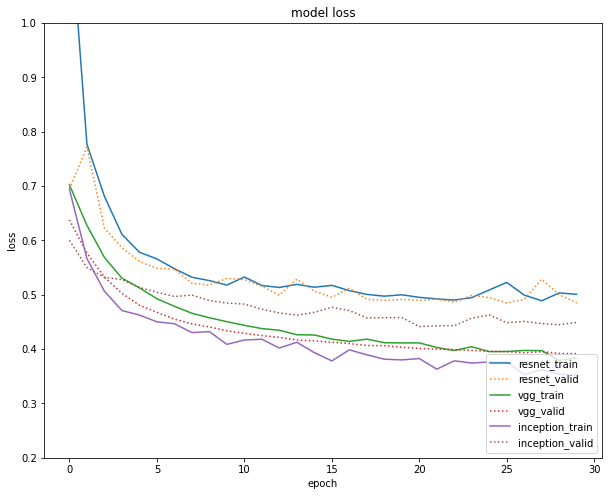

In [74]:
plot_model_loss(model_history)

### Manual method of constructing train and test datasets for Keras Tuner

In this section, we will build up the train and validation datasets manually so that we can use Keras Tuner functionality to tune the hyperparameters of a simpler sequential neural network. Keras provides a lot of flexibility whe we construct our own deep learning framework, and this enables easy tuning of hyperparamters across the network, such as batch size, the width of hidden layers, the learning rate, dropout rate, etc. Seeing that above the VGG16 model worked the best of the three frameworks tested, I will rebuild the architecture from scratch so that the weights of the full network can be trained, and the hypertuner can reasonably update each parameter to optimize the module.

Due to memory issues, this section was not very fruitful in the end.  The above pre-trained models still performed as good if not better than what tuned models I could yield below.

#### Build shuffled train and validation sets for X and Y from image folders

In [1]:
none_train_path = r'C:\Users\kenns\automatic_solar_pv_detection\images\balanced_set\train\none'
solar_train_path = r'C:\Users\kenns\automatic_solar_pv_detection\images\balanced_set\train\solar'
none_valid_path = r'C:\Users\kenns\automatic_solar_pv_detection\images\balanced_set\valid\none'
solar_valid_path = r'C:\Users\kenns\automatic_solar_pv_detection\images\balanced_set\valid\solar'

In [3]:
none_train_dir = np.array(os.listdir(none_train_path))
solar_train_dir = np.array(os.listdir(solar_train_path))
none_valid_dir = np.array(os.listdir(none_valid_path))
solar_valid_dir = np.array(os.listdir(solar_valid_path))

In [4]:
def get_images(img_dir, path):
    imgs = []
    for tif in tqdm(img_dir):
        img = imageio.imread(os.path.join(path, tif))
        imgs.append(img[:, :, 0:3]) # [0:3] -> R,G,B, [1:4] -> G,B,NIR, just [4] -> NIR
    return np.array (imgs) / 255

In [5]:
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
# needed a way to shuffle the two train and validation sets for X and Y in unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [6]:
none_train = get_images(none_train_dir, none_train_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:04<00:00, 112.40it/s]


In [7]:
none_valid = get_images(none_valid_dir, none_valid_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:01<00:00, 91.33it/s]


In [8]:
solar_train = get_images(solar_train_dir, solar_train_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:07<00:00, 74.86it/s]


In [9]:
solar_valid = get_images(solar_valid_dir, solar_valid_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:01<00:00, 70.41it/s]


In [10]:
# concatenate training arrays for solar and none, and build Y array with 1s and 0s for labels
X_train = np.concatenate((solar_train, none_train), axis=0)
Y_train = np.array([1]*len(solar_train) + [0]*len(none_train), dtype='float32').reshape(-1,1)

In [11]:
# concatenate validation arrays for solar and none, and build Y array with 1s and 0s for labels
X_test = np.concatenate((solar_valid, none_valid), axis=0)
Y_test = np.array([1]*len(solar_valid) + [0]*len(none_valid), dtype='float32').reshape(-1,1)

In [12]:
# shuffle the X and Y arrays in unison so that labels align with 3D matrix of scaled RGB values for each image 
X_train, Y_train = unison_shuffled_copies(X_train, Y_train)
X_test, Y_test = unison_shuffled_copies(X_test, Y_test)

In [13]:
# confirm the shape of the X and Y objects prior to training the model
print('X training set: ', X_train.shape)
print('Y training set: ', Y_train.shape)
print('X validation set: ', X_test.shape)
print('Y validation set: ', Y_test.shape)

X training set:  (1100, 100, 100, 3)
Y training set:  (1100, 1)
X validation set:  (276, 100, 100, 3)
Y validation set:  (276, 1)


#### Build a vanilla network with a few hidden convolutional layers

Here I attempt to use a simpler deep neural network that sort of emulates the modules found in the beginning of Inception or throughout the VGG framework. This means stacking multiple convolutional layers followed by max pooling, with an average pooling layer at the end, before flattening, passing through a fully connected layer, and the sigmoid classification layer.

In [14]:
IMAGE_INPUT_SHAPE = X_train.shape[1:]

In [18]:
def build_simple_nn():
    inputs = tf.keras.Input(shape=IMAGE_INPUT_SHAPE)
    x = inputs
    
    # first stage
    x = Conv2D(filters = 64, 
            kernel_size =(5,5),
            activation='relu',
            padding='same')(x)
    x = Conv2D(filters = 128, 
            kernel_size =(3,3),
            activation='relu',
            padding='same')(x)
    x = Conv2D(filters = 256, 
            kernel_size =(1,1),
            activation='relu',
            padding='same')(x)
    x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
    
    # second stage
    x = Conv2D(filters = 512, 
            kernel_size =(3,3),
            activation='relu',
            padding='same')(x)
    x = Conv2D(filters = 512, 
            kernel_size =(3,3),
            activation='relu',
            padding='same')(x)
    x = AvgPool2D(pool_size=(2,2), strides=(2,2))(x)
    
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(units=1, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy', 
        metrics=['accuracy'])
    print(model.summary())
    
    return model

In [19]:
simple_model = build_simple_nn()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 64)      4864      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 256)     33024     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 512)       1180160   
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 512)      

In [20]:
simple_history = simple_model.fit(
    X_train, Y_train, 
    epochs=30, 
    validation_data=(X_test, Y_test))

Epoch 1/30
35/35 [==============================] - 11s 323ms/step - loss: 0.9197 - accuracy: 0.5382 - val_loss: 0.6746 - val_accuracy: 0.5145
Epoch 2/30
35/35 [==============================] - 10s 280ms/step - loss: 0.6074 - accuracy: 0.6973 - val_loss: 0.4825 - val_accuracy: 0.7862
Epoch 3/30
35/35 [==============================] - 10s 282ms/step - loss: 0.4978 - accuracy: 0.7791 - val_loss: 0.4652 - val_accuracy: 0.7899
Epoch 4/30
35/35 [==============================] - 10s 283ms/step - loss: 0.4912 - accuracy: 0.7682 - val_loss: 0.5741 - val_accuracy: 0.6196
Epoch 5/30
35/35 [==============================] - 10s 285ms/step - loss: 0.4654 - accuracy: 0.7827 - val_loss: 0.6643 - val_accuracy: 0.6884
Epoch 6/30
35/35 [==============================] - 10s 283ms/step - loss: 0.6736 - accuracy: 0.5773 - val_loss: 0.6661 - val_accuracy: 0.4891
Epoch 7/30
35/35 [==============================] - 10s 287ms/step - loss: 0.5988 - accuracy: 0.7018 - val_loss: 0.5638 - val_accuracy: 0.7645

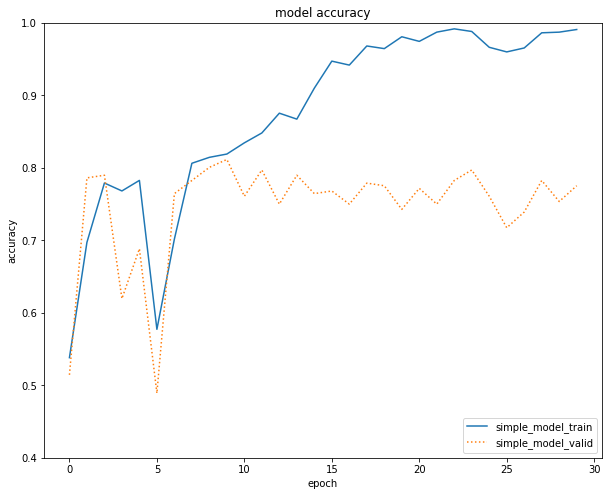

In [25]:
plot_model_accuracy({'simple_model' : simple_history})

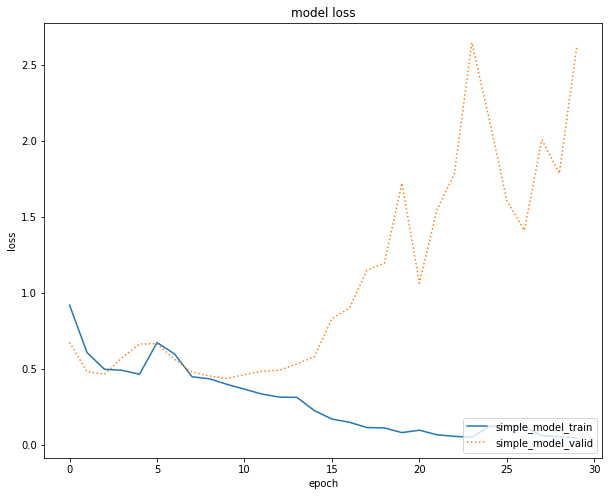

In [27]:
plot_model_loss({'simple_model' : simple_history})

As we can see above, the model begins of overfit rather quickly after the fourth epoc.  The model quickly optimizes its weights in the first 4 epochs seeing a consistent drop and divergence in train and validation loss in tandem to concurrent increating in train and validation accuracy. Starting in the fifth epoch, the validation accuracy decreases and loss increases steeply. Prior to overfitting, this model achives performance similar to the API models above.

#### Build VGG16 model within the hyperparamter space

The cells below are not needed to be ran. In fact, they will likely fail due to a memory error received from the hyperparamter space being too large. Below I attempted to use the Keras Tuner library to tune the hyperparamters of the VGG16 model. The first attempt failed because the hp.Int() method only picked one value to modify the filter size per trial. All of the layers ended up with the same filter size. In the second approach I tried to build up the VGG model dynamically by adding a each convolutional module with increasing filter size (ranging from 64 to 512 as in the original model). This crashes the TF kernel as well, so the hyperparameter tuning was largely unsuccessful.

In [113]:
def build_hyper_vgg16_model_1(hp):
    model = Sequential()
    
    # first stage two layers of 3x3x64
    model.add(Conv2D(input_shape=IMAGE_INPUT_SHAPE,
        filters=hp.Int('filters',
            min_value=32,
            max_value=96,
            step=32),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(Conv2D(filters=hp.Int('filters',
            min_value=32,
            max_value=96,
            step=32),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    
    # second stage two layers of 3x3x128
    model.add(Conv2D(filters=hp.Int('filters',
            min_value=96,
            max_value=160,
            step=32),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(Conv2D(input_shape=IMAGE_INPUT_SHAPE, filters=
        hp.Int('filters',
            min_value=96,
            max_value=160,
            step=32),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    
    # third stage three layers of 3x3x256
    model.add(Conv2D(filters=hp.Int('filters',
            min_value=192,
            max_value=320,
            step=64),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(Conv2D(input_shape=IMAGE_INPUT_SHAPE, filters=
        hp.Int('filters',
            min_value=192,
            max_value=320,
            step=64),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(Conv2D(input_shape=IMAGE_INPUT_SHAPE, filters=
        hp.Int('filters',
            min_value=192,
            max_value=320,
            step=64),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    
    # fourth stage three layers of 3x3x512
    model.add(Conv2D(filters=hp.Int('filters',
            min_value=384,
            max_value=640,
            step=128),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(Conv2D(input_shape=IMAGE_INPUT_SHAPE, filters=
        hp.Int('filters',
            min_value=384,
            max_value=640,
            step=128),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(Conv2D(input_shape=IMAGE_INPUT_SHAPE, filters=
        hp.Int('filters',
            min_value=384,
            max_value=640,
            step=128),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    
    # fifth stage three layers of 3x3x512
    model.add(Conv2D(filters=hp.Int('filters',
            min_value=384,
            max_value=640,
            step=128),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(Conv2D(input_shape=IMAGE_INPUT_SHAPE, filters=
        hp.Int('filters',
            min_value=384,
            max_value=640,
            step=128),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(Conv2D(input_shape=IMAGE_INPUT_SHAPE, filters=
        hp.Int('filters',
            min_value=384,
            max_value=640,
            step=128),
        activation='relu',
        kernel_size=(3,3),
        padding="same"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    
    # sixth stage flatten two relu dense and classification header
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy', 
        metrics=['accuracy'])
    print(model.summary())
    return model

As can be seen below, the hyperparameter tuner only chose a single filter size value and applied it to all the layers, this doesn't work for our use-case even though the best model still got 81% validation accuracy, which is on par with the most performant model above.

In [116]:
tuner = RandomSearch(
    build_hyper_vgg16_model_1,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='log_dir',
    project_name='solar_pv_class')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 32)        9

In [117]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [119]:
tuner.search(X_train, Y_train, 
    epochs=5, 
    validation_data=(X_test, Y_test))

Trial 5 Complete [00h 00m 50s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.8128019173940023
Total elapsed time: 00h 03m 20s
INFO:tensorflow:Oracle triggered exit


In [120]:
tuner.get_best_models(num_models=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 96)      2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 96)      83040     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 96)        83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 96)        83040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 96)        8

Because of the issue in imlementing the Keras Tuner library above on each convolutional layer of the VGG16 model, I need to dynamically build up the model, where each layer is at the scale respective to that stage in the model.

In [27]:
def build_hyper_vgg16_model_2(hp):
    inputs = tf.keras.Input(shape=IMAGE_INPUT_SHAPE)
    x = inputs
    for i in range(1, 6):
        if i == 1:
            x = Conv2D(
                filters=hp.Int('filters_' + str(i),
                    32, 96, step=32, default=64),
                kernel_size=(3,3),
                activation='relu',
                padding='same')(x)
        if i == 2:
            x = Conv2D(
                filters=hp.Int('filters_' + str(i),
                    96, 160, step=32, default=128),
                kernel_size=(3,3),
                activation='relu',
                padding='same')(x)
        elif i == 3:
            x = Conv2D(
                filters=hp.Int('filters_' + str(i),
                    192, 320, step=64, default=256),
                kernel_size=(3,3),
                activation='relu',
                padding='same')(x)            
        else:
            for j in range(1, 3):
                x = Conv2D(
                    filters=hp.Int('filters_' + str(i),
                        384, 640, step=128, default=512),
                    kernel_size=(3,3),
                    activation='relu',
                    padding='same')(x)
                
        x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
        
    x = Flatten()(x)
    x = Dense(units=4096,activation="relu")(x)
    x = Dense(units=4096,activation="relu")(x)
    outputs = Dense(units=1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy', 
        metrics=['accuracy'])
    print(model.summary())
    
    return model

In [28]:
hyper_tuner = RandomSearch(
    build_hyper_vgg16_model_2,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=3,
    directory='log_dir_2',
    project_name='solar_pv_class')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)      

In [29]:
hyper_tuner.search_space_summary()

Search space summary
Default search space size: 6
filters_1 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': None}
filters_2 (Int)
{'default': 128, 'conditions': [], 'min_value': 96, 'max_value': 160, 'step': 32, 'sampling': None}
filters_3 (Int)
{'default': 256, 'conditions': [], 'min_value': 192, 'max_value': 320, 'step': 64, 'sampling': None}
filters_4 (Int)
{'default': 512, 'conditions': [], 'min_value': 384, 'max_value': 640, 'step': 128, 'sampling': None}
filters_5 (Int)
{'default': 512, 'conditions': [], 'min_value': 384, 'max_value': 640, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [30]:
hyper_tuner.search(X_train, Y_train, 
    epochs=10, 
    validation_data=(X_test, Y_test))

Trial 1 Complete [00h 01m 57s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.5
Total elapsed time: 00h 01m 57s
INFO:tensorflow:Oracle triggered exit


In [31]:
hyper_tuner.get_best_models(num_models=1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 96)      2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 96)      83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 96)      83040     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       110720    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)      

I keep running out of memory when attempting to run all hyperparater tuning options through the Keras Tuner. Perhaps this would be possible by using an iterative approach to manually building out the tuning infrastructure, but I don't believe this is worth my time. One other option would be to run this same script in a CoLab notebook or somewhere leveraging scalable computing resources.

## Appendix

### Summary of VGG, Inception and ResNet Architectures

![title](https://i.pinimg.com/originals/3a/01/b4/3a01b4e0f4daba9863b16a006d36f113.png)